In [2]:
import os
import random
import shutil
from torchinfo import summary
import torch
from torch import optim
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader,Dataset
import random
import pathlib
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from typing import Dict, List, Tuple
from torch import nn
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"
!rm /kaggle/working/Modular/models/model1.pth

rm: cannot remove '/kaggle/working/Modular/models/model1.pth': No such file or directory


In [3]:
# # Define paths
# input_directory = '/kaggle/input/modularfolder/Modular'
# output_directory = '/kaggle/working'

# # Copy directory and its files from input to working directory
# shutil.copytree(input_directory, os.path.join(output_directory, 'Modular'))

# print("Data copied successfully from input to working directory.")

In [4]:
# # Define paths
# training_folder = '/kaggle/working/Modular/data/ieee-supcom-internal-competition/Training'
# output_folder = '/kaggle/working/Modular/data/ieee-supcom-internal-competition'

# # List all subfolders (classes) in the training folder
# classes = os.listdir(training_folder)

# # Create the validation directory if it doesn't exist
# validation_folder = os.path.join(output_folder, 'Validation')
# if not os.path.exists(validation_folder):
#     os.makedirs(validation_folder)

# for class_name in classes:
#     class_folder = os.path.join(training_folder, class_name)
    
#     # List all files in the class folder
#     files = os.listdir(class_folder)
    
#     # Shuffle files (optional)
#     random.shuffle(files)
    
#     # Calculate split indices
#     split_index = int(len(files) * 0.2)
    
#     # Split files into training and validation sets
#     validation_files = files[:split_index]
#     training_files = files[split_index:]
    
#     # Move files to new folders (optional)
#     for file in validation_files:
#         class_output_folder = os.path.join(validation_folder, class_name)
#         if not os.path.exists(class_output_folder):
#             os.makedirs(class_output_folder)
#         shutil.move(os.path.join(class_folder, file), os.path.join(class_output_folder, file))
    
#     # Move files to new folders (optional)
#     for file in training_files:
#         class_output_folder = os.path.join(output_folder, 'Training', class_name)
#         if not os.path.exists(class_output_folder):
#             os.makedirs(class_output_folder)
#         shutil.move(os.path.join(class_folder, file), os.path.join(class_output_folder, file))

# print("Splitting completed successfully.")

In [5]:
####################################### CUSTOM DATASET PART ##########################################
# Make function to find classes in target directory
def find_classes(directory: str)-> tuple[list[str], dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.dataset = datasets.ImageFolder(targ_dir, transform=transform)
        self.targets = [target for _, target in self.dataset.samples]
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int)-> tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

class ImageFolderCustomForTest(ImageFolderCustom):
    def __init__(self, path_strings: list[str], transform=None) -> None:
        # . Create class attributes
        # Get all image paths
        self.paths = [pathlib.Path(path_string) for path_string in path_strings] # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform

    # . Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int)-> torch.Tensor:
        "Returns one sample of data"
        img = self.load_image(index)
        # Transform if necessary
        if self.transform:
            return self.transform(img) # return data-transformed
        else:
            return img # return data



############################################ BASIC DATASET PART #####################################
def create_train_dataloader(train_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int):

  data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=transform)
  
  # Get class names
  class_names = data_custom.classes

  # Turn images into data loaders
  dataloader = DataLoader(
      data_custom,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
      collate_fn=custom_collate
  )

  return dataloader, class_names

def create_val_dataloader(val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int):

  data_custom = ImageFolderCustom(targ_dir=val_dir, 
                                      transform=transform)

  # Get class names
  class_names = data_custom.classes

  # Turn images into data loaders
  dataloader = DataLoader(
      data_custom,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      collate_fn=custom_collate
  )

  return dataloader, class_names

def create_submit_dataloader(path_strings: str, transform: transforms.Compose, batch_size: int, num_workers: int):

  data_custom = ImageFolderCustomForTest(path_strings=path_strings, 
                                      transform=transform)

  # Turn images into data loaders
  dataloader = DataLoader(
      data_custom,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      collate_fn=custom_collate_submit
  )

  return dataloader

def custom_collate(batch):
    """
    Custom collate function to create batches from variable-sized grayscale images.
    
    Args:
    - batch: A list of tuples (X, y), where X is a list of variable-sized grayscale images represented as tensors,
            and y is the target tensor.
    
    Returns:
    - X_padded: Padded images as a tensor.
    - y: Target tensor.
    """
    images = [item[0] for item in batch]
    # Get the maximum height and width in the batch
    max_height = max(image[0].shape[1] for image in batch)
    max_width = max(image[0].shape[2] for image in batch)

    resize_transform = transforms.Compose([
        transforms.Resize((max_height, max_width))
    ])
    
    resized_images = [resize_transform(image) for image in images]
    # Pad images to the same size
    X_padded = torch.stack([torch.nn.functional.pad(image, 
                                                    (0, max_width - image.shape[1], 
                                                     0, max_height - image.shape[2]))
                            for image in resized_images])
    
    # Create tensor for target variable y
    y = torch.tensor([item[1] for item in batch])
    
    return X_padded, y

def custom_collate_submit(batch):
    """
    Custom collate function to create batches from variable-sized grayscale images.
    
    Args:
    - batch: A list of tuples (X, y), where X is a list of variable-sized grayscale images represented as tensors,
            and y is the target tensor.
    
    Returns:
    - X_padded: Padded images as a tensor.
    - y: Target tensor.
    """
    max_height = max(image.shape[1] for image in batch)
    max_width = max(image.shape[2] for image in batch)

    resize_transform = transforms.Compose([
        transforms.Resize((max_height, max_width))
    ])
    
    resized_images = [resize_transform(image) for image in batch]
    # Pad images to the same size
    X_padded = torch.stack([torch.nn.functional.pad(image, 
                                                    (0, max_width - image.shape[1], 
                                                     0, max_height - image.shape[2]))
                            for image in resized_images])
    
    
    return X_padded

In [6]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """vals a PyTorch model for a single epoch.

  Turns a target PyTorch model to "val" mode and then performs
  a forward pass on a valing dataset.

  Args:
    model: A PyTorch model to be valed.
    dataloader: A DataLoader instance for the model to be valed on.
    loss_fn: A PyTorch loss function to calculate loss on the val data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of valing loss and valing accuracy metrics.
    In the form (val_loss, val_accuracy). For example:

    (0.0223, 0.8985)
  """
  
  # Put model in val mode
  model.eval() 

  # Setup val loss and val accuracy values
  val_loss, val_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          val_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(val_pred_logits, y)
          val_loss += loss.item()

          # Calculate and accumulate accuracy
          val_pred_labels = val_pred_logits.argmax(dim=1)
          val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          scheduler,state_dicts) -> Dict[str, List]:
  """Trains and vals a PyTorch model.

  Passes a target PyTorch models through train_step() and val_step()
  functions for a number of epochs, training and valing the model
  in the same epoch loop.

  Calculates, prints and stores valuation metrics throughout.

  Args:
    model: A PyTorch model to be trained and valed.
    train_dataloader: A DataLoader instance for the model to be trained on.
    val_dataloader: A DataLoader instance for the model to be valed on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and valing loss as well as training and
    valing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  val_loss: [...],
                  val_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  val_loss: [1.2641, 1.5706],
                  val_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
  }

  # Loop through training and valing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      val_loss, val_acc = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)
      scheduler.step()  # Update the learning rate scheduler at the end of each epoch
      state_dict_copy = {key: value.clone().detach() for key, value in model.state_dict().items()}
      state_dicts.append(state_dict_copy)

      # Print out what's happening
      print(
          f"\nEpoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}|"
          f"LR: {optimizer.param_groups[0]['lr']}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["val_loss"].append(val_loss)
      results["val_acc"].append(val_acc)

  # Return the filled results at the end of the epochs
  return results

In [7]:
# %load /kaggle/working/Modular/scripts/utils.py
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [8]:
# device="cuda"
# #modelV1
# weightsV1 = models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
# modelV1 = models.efficientnet_b0(weights=weightsV1).to(device)
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in modelV1.parameters():
#     param.requires_grad = False

# # Get the length of class_names (one output unit for each class)
# output_shape = 4
# # Recreate the classifier layer and seed it to the target device
# modelV1.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.6),
#     torch.nn.Linear(in_features=1280, out_features=4,bias=True),
#     ).to(device)

In [9]:
# #modelV2
# weights = models.RegNet_Y_128GF_Weights.DEFAULT # .DEFAULT = best available weights 
# modelV2 = models.regnet_y_128gf(weights=weights).to(device)
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in modelV2.parameters():
#     param.requires_grad = False
# # Get the length of class_names (one output unit for each class)
# output_shape = 4
# # Recreate the classifier layer and seed it to the target device
# modelV2.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.5), 
#     torch.nn.Linear(in_features=7392, out_features=4,bias=True),
#     ).to(device)

In [10]:
# #modelV3
# weights = models.RegNet_Y_32GF_Weights.DEFAULT # .DEFAULT = best available weights 
# modelV3 = models.regnet_y_32gf(weights=weights).to(device)
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in modelV3.parameters():
#     param.requires_grad = False
# # Get the length of class_names (one output unit for each class)
# output_shape = 4

# # Recreate the classifier layer and seed it to the target device
# modelV3.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.5), 
#     torch.nn.Linear(in_features=3712, out_features=4,bias=True),
#     ).to(device)

In [23]:

#modelV4
weights = models.Wide_ResNet152_Weights.DEFAULT  # .DEFAULT = best available weights 
modelV1 = models.wide_resnet152(weights=weights).to(device)
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in modelV1.parameters():
    param.requires_grad = False
# Get the length of class_names (one output unit for each class)
output_shape = 4
# Recreate the classifier layer and seed it to the target device
modelV1.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5), 
    torch.nn.Linear(in_features=2048, out_features=4,bias=True),
    ).to(device)

AttributeError: module 'torchvision.models' has no attribute 'Wide_ResNet152_Weights'

In [12]:

# #modelV5
# weights = models.ResNet101_Weights.DEFAULT  # .DEFAULT = best available weights 
# modelV5 = models.resnet101(weights=weights).to(device)
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in modelV5.parameters():
#     param.requires_grad = False
# # Get the length of class_names (one output unit for each class)
# output_shape = 4
# # Recreate the classifier layer and seed it to the target device
# modelV5.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.3), 
#     torch.nn.Linear(in_features=2048, out_features=4,bias=True),
#     ).to(device)

In [13]:

# #modelV6
# weights = models.ResNeXt50_32X4D_Weights.DEFAULT  # .DEFAULT = best available weights 
# modelV6 = models.resnext50_32x4d(weights=weights).to(device)
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in modelV6.parameters():
#     param.requires_grad = False
# # Get the length of class_names (one output unit for each class)
# output_shape = 4
# # Recreate the classifier layer and seed it to the target device
# modelV6.fc = torch.nn.Sequential(
#     torch.nn.Linear(in_features=2048, out_features=4,bias=True),
#     ).to(device)

In [14]:
import cv2
import numpy as np

class ErodeRGB:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img_np = np.array(img)
        
        # Apply erosion to each channel separately
        eroded_channels = []
        for channel in range(3):
            channel_img = img_np[:, :, channel]
            eroded_channel = cv2.erode(channel_img, np.ones((self.kernel_size, self.kernel_size), np.uint8), iterations=1)
            eroded_channels.append(eroded_channel)
        
        # Stack eroded channels to form a 3-channel image
        img_np_eroded = np.stack(eroded_channels, axis=-1)
        
        # Convert back to PIL Image
        img_eroded = Image.fromarray(img_np_eroded, 'RGB')
        
        return img_eroded
class PreprocessImage:
    def __call__(self, img):
        # Preprocess the image using the preprocess_image function
        processed_img = preprocess_image(img)
        return processed_img
def preprocess_image(img):
    # Read image using OpenCV
    img = np.array(img)

    # Resize the image
    img = cv2.resize(img, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Threshold the image
    thresh = cv2.threshold(gray,45 , 255, cv2.THRESH_BINARY)[1]
    
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    
    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Define pixels to add for cropping
    ADD_PIXELS = 0
    
    # Crop the image
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()    
    # Convert numpy array to PIL image
    new_img_pil = Image.fromarray(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

    
    return new_img_pil
class DilateRGB:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img_np = np.array(img)
        
        # Apply dilation to each channel separately
        dilated_channels = []
        for channel in range(3):
            channel_img = img_np[:, :, channel]
            dilated_channel = cv2.dilate(channel_img, np.ones((self.kernel_size, self.kernel_size), np.uint8), iterations=1)
            dilated_channels.append(dilated_channel)
        
        # Stack dilated channels to form a 3-channel image
        img_np_dilated = np.stack(dilated_channels, axis=-1)
        
        # Convert back to PIL Image
        img_dilated = Image.fromarray(img_np_dilated, 'RGB')
        
        return img_dilated

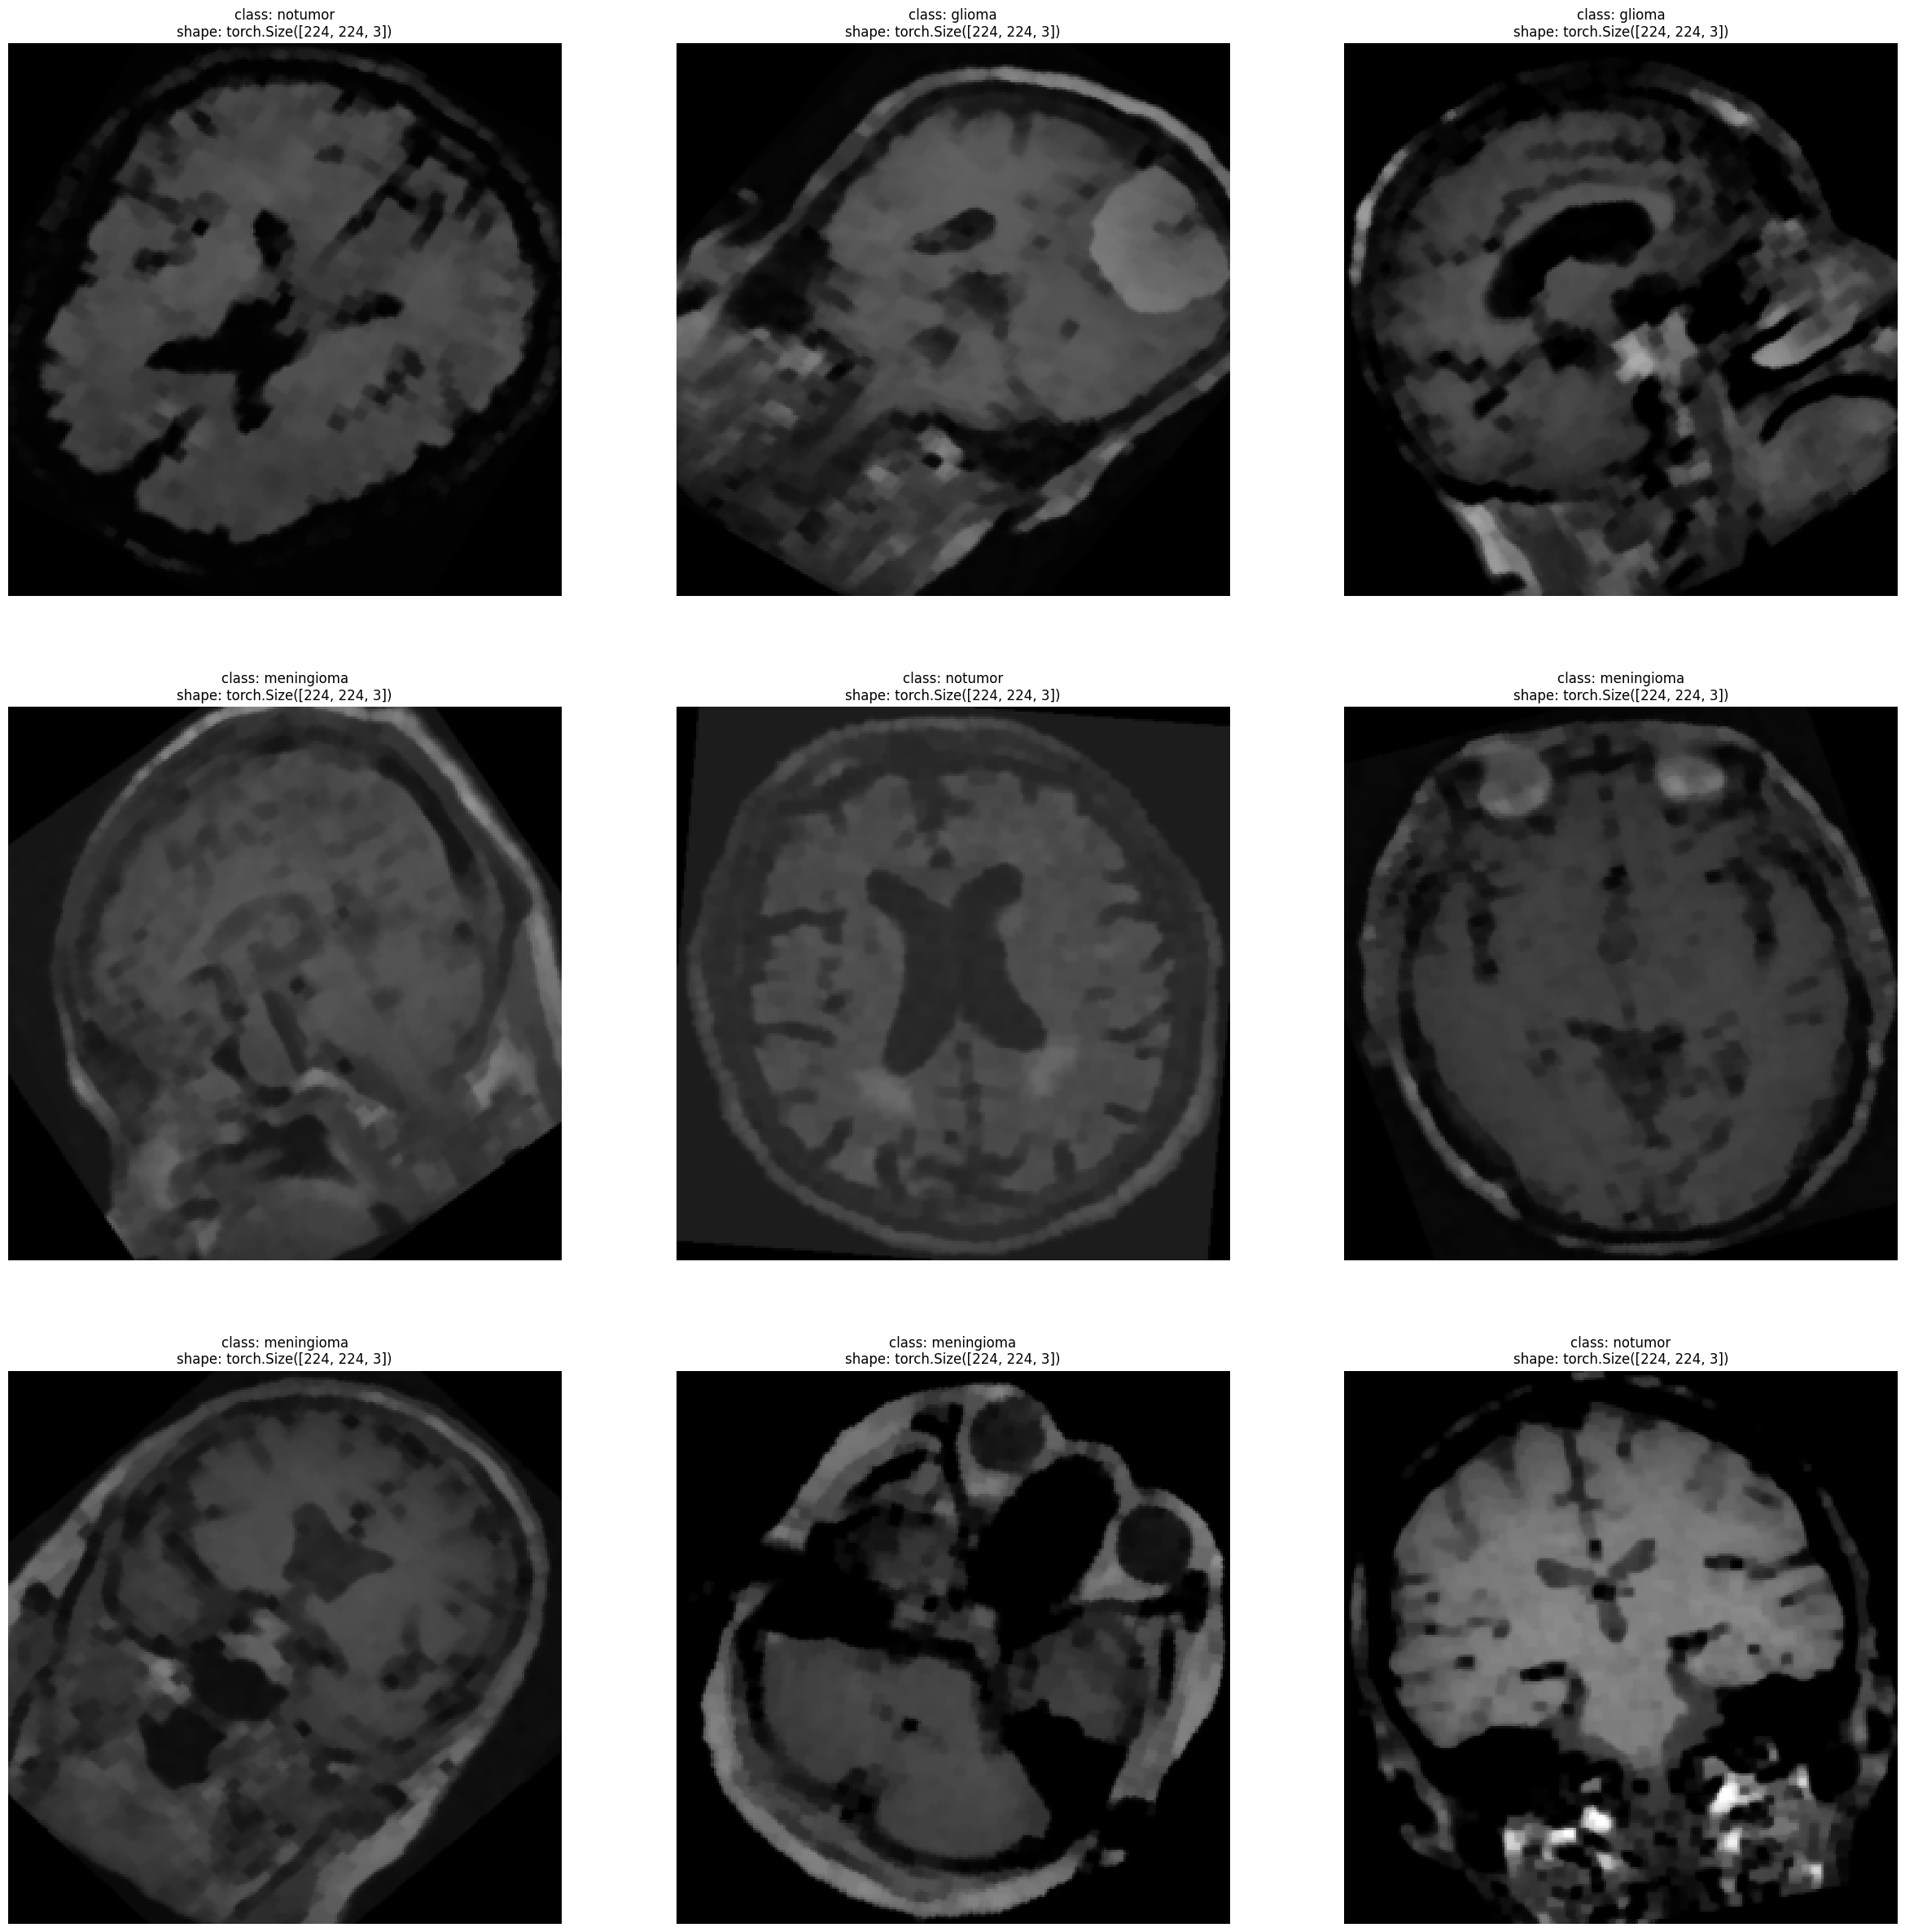

In [22]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(30, 30))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(3, 3, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


train_dir = "/kaggle/input/modularfolder/Modular/data/ieee-supcom-internal-competition/Training"
mean = [0.4, 0.4, 0.2]
std = [0.4, 0.2, 0.4]
data_transform = transforms.Compose([
    transforms.ElasticTransform(alpha=50.0, sigma=5.0, fill=0),
    PreprocessImage(),
    ErodeRGB(10),
    DilateRGB(5),
    #transforms.CenterCrop(size=(360, 360)),
    transforms.ColorJitter(brightness=0.2, contrast=1, saturation=0, hue=0),  # Random brightness adjustment
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=50),
    transforms.Resize((224,224), antialias=True),
    transforms.ToTensor(),  # Add this line,
])

import matplotlib.pyplot as plt
data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=data_transform)
# Display random images from ImageFolder created Dataset
display_random_images(data_custom, 
                      n=9,
                      classes=['pituitary','glioma','notumor','meningioma'],
                      seed=8)

In [ ]:
k_fold=8
train_dir = "/kaggle/input/modularfolder/Modular/data/ieee-supcom-internal-competition/Training"
dataset = ImageFolderCustom(targ_dir=train_dir, transform=data_transform)
NUM_EPOCHS=6
NUM_WORKERS=4
BATCH_SIZE=32
LEARNING_RATE=0.003
train_score = pd.Series()
val_score = pd.Series()
total_size = len(dataset)
fraction = 1/k_fold
seg = int(total_size * fraction)
device="cuda"
# tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
# index: [trll,trlr],[vall,valr],[trrl,trrr]
STATE=[]
for i in range(k_fold):
    #modelV4
    weights = models.ResNet152_Weights.DEFAULT  # .DEFAULT = best available weights 
    modelV1 = models.resnet152(weights=weights).to(device)
    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in modelV1.parameters():
        param.requires_grad = False
    # Get the length of class_names (one output unit for each class)
    output_shape = 4
    # Recreate the classifier layer and seed it to the target device
    modelV1.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.5), 
        torch.nn.Linear(in_features=2048, out_features=4,bias=True),
    ).to(device)
    trll = 0
    trlr = i * seg
    vall = trlr
    valr = i * seg + seg
    trrl = valr
    trrr = total_size
    print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
          % (trll,trlr,trrl,trrr,vall,valr))

    train_left_indices = list(range(trll,trlr))
    train_right_indices = list(range(trrl,trrr))

    train_indices = train_left_indices + train_right_indices
    val_indices = list(range(vall,valr))

    train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
    val_set = torch.utils.data.dataset.Subset(dataset,val_indices)

    print(len(train_set),len(val_set))
    print()

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                      shuffle=True, num_workers=NUM_WORKERS,
                                      collate_fn=custom_collate)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                      shuffle=True, num_workers=NUM_WORKERS,
                                      collate_fn=custom_collate)
    # Set the manual seeds
    torch.cuda.manual_seed(42)

    modelV1.to(device)
    state_dicts=[]

    # Start training
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelV1.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
    print("################"+str(i)+"#################")
    train(model=modelV1,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        device=device,
        scheduler=scheduler,state_dicts=state_dicts)
    STATE.append(state_dicts)
    # Save the model
    save_model(model=modelV1,
                target_dir="/kaggle/working/Modular/models",
                model_name="modelV"+str(i+1)+".pth")

train indices: [0,0),[653,5229), test indices: [0,653)
4576 653

################0#################


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
modelV1.load_state_dict(STATE[0][5])


In [ ]:
state_dicts

In [ ]:
metric = ConfusionMatrix(num_classes=4)
metric.attach(default_evaluator, 'cm')
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics['cm'])

In [ ]:
# %load /kaggle/working/Modular/scripts/predict.py
device="cpu"
import pandas as pd
prefix=Path("/kaggle/input/modularfolder/Modular/data/ieee-supcom-internal-competition/Testing")
sample_submission=pd.read_csv('/kaggle/input/modularfolder/Modular/data/ieee-supcom-internal-competition/submission_attempt.csv', dtype={'ID': str})
paths=[prefix / Path(row+".jpg") for row in sample_submission['ID']]
columns = ['ID','Label'] #this matters a lot
output_df = pd.DataFrame(columns=columns)
output_df['ID']=[str(path)[82:-4] for path in paths] #70 to remove the useless path part , -3 to remove the extension of the image , all of this to just leave the name

NUM_WORKERS=4
BATCH_SIZE=32

data_transform = transforms.Compose([
    PreprocessImage(),
    ErodeRGB(3),
    #transforms.CenterCrop(size=(360, 360)),
    #transforms.ColorJitter(brightness=0.1, contrast=3, saturation=0, hue=0),  # Random brightness adjustment
    transforms.Resize((224,224), antialias=True),
    transforms.ToTensor(),  # Add this line,
])
modelV1.to(device)
y=[]
submission_dataloader=create_submit_dataloader(
path_strings=paths,
transform=data_transform,
batch_size=BATCH_SIZE,
num_workers=NUM_WORKERS)
for batch,X in enumerate(submission_dataloader):
    X.to(device)
    with torch.inference_mode():
        Y=modelV1(X)
        print(f'batch{batch+1}')
        elm=torch.argmax(torch.softmax(Y,dim=1),dim=1).tolist()
        y.extend(elm)

In [ ]:
def fill(output_df,y):
    for idx, prediction in enumerate(y):
        output_df.loc[idx, 'Label'] = prediction

fill(output_df, y)

output_df.to_csv('zaama?.csv', index=False)

In [ ]:
# import pandas as pd
# prefix=Path("/kaggle/working/Modular/data/ieee-supcom-internal-competition/Testing")
# sample_submission=pd.read_csv('/kaggle/working/Modular/data/ieee-supcom-internal-competition/submission_attempt.csv', dtype={'ID': str})
# paths=[prefix / Path(row+".jpg") for row in sample_submission['ID']]
# columns = ['ID','Label'] #this matters a lot
# output_df = pd.DataFrame(columns=columns)
# output_df['ID']=[str(path)[70:-4] for path in paths] #70 to remove the useless path part , -3 to remove the extension of the image , all of this to just leave the name

# NUM_WORKERS=os.cpu_count()
# BATCH_SIZE=32

# data_transform = transforms.Compose([
#     PreprocessImage(),
#     #transforms.CenterCrop(size=(360, 360)),
#     #transforms.ColorJitter(brightness=0.1, contrast=2, saturation=0.2, hue=0.3),  # Random brightness adjustment
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),  # Add this line
# ])
# submission_dataloader=create_submit_dataloader(
#     path_strings=paths,
#     transform=data_transform,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS
#     )
# y=[]
# device="cpu"
# modelV1.to(device)
# for batch,X in enumerate(submission_dataloader):
#     with torch.inference_mode():
#         Y=modelV1(X)
#         elm=torch.argmax(torch.softmax(Y,dim=1),dim=1).tolist()
#         y.extend(elm)
# y_final=y
# def fill(output_df,y_final):
#     for idx, prediction in enumerate(y_final):
#         output_df.loc[idx, 'Label'] = prediction

# fill(output_df, y_final)

# output_df.to_csv('ENSEMBLE.csv', index=False)